In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.pyplot as plt
import os

np.random.seed(2018)

/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Read data:

In [3]:
batch_size = 64
input_size = (229, 229, 3)

train_img_gen =  ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_img_gen = ImageDataGenerator()

train_data_gen = train_img_gen.flow_from_directory('train_split', (input_size[0], input_size[1]), class_mode='binary', shuffle=True, batch_size=batch_size)
val_data_gen = val_img_gen.flow_from_directory('val_split', (input_size[0], input_size[1]), class_mode='binary', shuffle=False, batch_size=batch_size)


Found 19944 images belonging to 2 classes.
Found 4985 images belonging to 2 classes.


### Build model:

In [4]:
# base model
x_input = Input(input_size)
x_input = Lambda(xception.preprocess_input)(x_input)
base_model = Xception(input_tensor=x_input, weights='imagenet', include_top=False)
for layer in base_model.layers[:-6]:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)

# top layers
top_model = load_model('Xception_top_layers.h5')
# x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='top_sigmoid', weights=top_model.get_weights())(x)

model = Model(base_model.input, x)

opt = optimizers.SGD(lr=1e-4, momentum=0.5, decay=1e-6)
# opt = optimizers.Adam(lr=1e-4, decay=1e-6)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
for layer in top_model.layers:
    print(layer.name)

input_4
dropout_4
top_sigmoid


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 229, 229, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         lambda_5[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

### Test pretrained model:

In [7]:
model.evaluate_generator(val_data_gen, steps=len(val_data_gen))

[0.03199332598676212, 0.9893681043129389]

### Train model:

In [5]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
             ModelCheckpoint(filepath='Xception_model.h5', monitor='val_loss', verbose=0, save_best_only=True)]
history = model.fit_generator(train_data_gen, steps_per_epoch=len(train_data_gen)/10, epochs=50,
                              validation_data=val_data_gen, validation_steps=len(val_data_gen), callbacks=callbacks)

Epoch 1/50
32/31 [==============================] - 63s 2s/step - loss: 0.4821 - acc: 0.7900 - val_loss: 0.0405 - val_acc: 0.9858
Epoch 2/50
32/31 [==============================] - 52s 2s/step - loss: 0.5275 - acc: 0.7852 - val_loss: 0.0387 - val_acc: 0.9858
Epoch 3/50
32/31 [==============================] - 52s 2s/step - loss: 0.4694 - acc: 0.8091 - val_loss: 0.0382 - val_acc: 0.9858
Epoch 4/50
32/31 [==============================] - 52s 2s/step - loss: 0.4732 - acc: 0.7974 - val_loss: 0.0373 - val_acc: 0.9862
Epoch 5/50
32/31 [==============================] - 53s 2s/step - loss: 0.4251 - acc: 0.8213 - val_loss: 0.0365 - val_acc: 0.9870
Epoch 6/50
32/31 [==============================] - 54s 2s/step - loss: 0.4273 - acc: 0.8101 - val_loss: 0.0358 - val_acc: 0.9872
Epoch 7/50
32/31 [==============================] - 51s 2s/step - loss: 0.4169 - acc: 0.8223 - val_loss: 0.0352 - val_acc: 0.9876
Epoch 8/50
32/31 [==============================] - 51s 2s/step - loss: 0.4297 - acc: 0.80

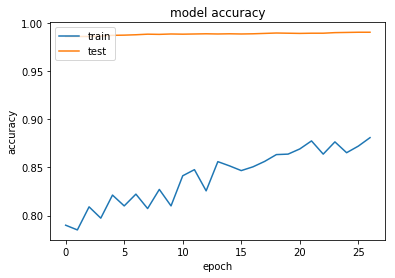

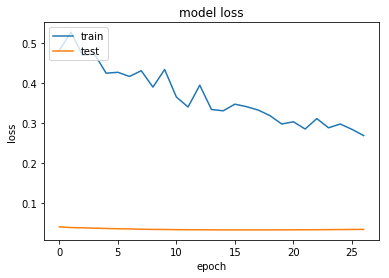

In [6]:
plot_history(history)

### Save model:

In [ ]:
if os.path.isfile('Xception_model.h5'):
    os.remove('Xception_model.h5')

model.save_model('Xception_model.h5')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


### Train in total tarining data:

In [ ]:
batch_size = 16
input_size = (229, 229, 3)

img_gen = ImageDataGenerator()
total_train_data_gen = img_gen.flow_from_directory('train', (input_size[0], input_size[1]), class_mode='binary', batch_size=batch_size)

In [ ]:
model.fit_generator(total_train_data_gen, math.ceil(total_train_data_gen.samples/batch_size))

### Predict:

In [ ]:
img_gen = ImageDataGenerator()
test_data_gen = img_gen.flow_from_directory('test', (input_size[0], input_size[1]), shuffle=False, batch_size=batch_size)

In [ ]:
y_pred = model.predict(test_data_gen, math.ceil(test_data_gen.samples/batch_size), verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [ ]:
df = pd.read_csv("sampleSubmission.csv")

for i, fname in enumerate(test_data_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred[i]

df.to_csv('pred.csv', index=None)
df.head(10)
